# Semi-Supervised Learning with MNIST

## Introduction

In this Google Colab notebook, we'll dive into semi-supervised learning using the MNIST dataset and PyTorch. Semi-supervised learning is a powerful approach that leverages both labeled and unlabeled data during the training process. This technique is especially valuable in real-world scenarios where obtaining labeled data can be costly or time-consuming.

Our exploration will be inspired by the concept of Soft Teacher, originally proposed for object detection in the paper "[End-to-End Semi-Supervised Object Detection with Soft Teacher](https://arxiv.org/pdf/2106.09018)". While Soft Teacher was designed for complex object detection tasks, we'll adapt its core principles to the simpler domain of handwritten digit recognition using the MNIST dataset.


![Soft Teacher](https://drive.google.com/uc?export=view&id=1PDKum-ix3xRtvm64W1pkUh0-LYoJ106n)


The figure above illustrates the Soft Teacher approach.
In our training process, we utilize two key components: a Soft Teacher and a Student Model. The Soft Teacher is continually updated using an exponential moving average of the Student Model's parameters.
Our training loop handles two distinct types of data:

1. Labeled Data: This is used directly to train the Student Model through standard supervised learning techniques.
2. Unlabeled Data: This is processed differently by the Soft Teacher and the Student Model:
    *  The Soft Teacher receives weakly augmented versions of the unlabeled data.
    *  The Student Model, in contrast, works with strongly augmented versions of the same unlabeled data.

In this example, we omit the bounding box prediction step. Instead, we train the student model using a loss calculated from two sources: the labeled data and the unlabeled data. For the unlabeled data, pseudo-labels are created by the Soft Teacher.


## Import Dependencies
For this tutorial, we'll primarily use PyTorch and a few related libraries. Let's import the necessary modules.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import copy
from itertools import cycle
import random

## Prepare MNIST Dataset for Semi-Supervised Learning


### Download MNIST Dataset

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Split Dataset into Labeled and Unlabeled Dataset

In [3]:
num_labeled = int(0.05 * len(mnist_train))

# Split training data into labeled and unlabeled sets
indices = list(range(len(mnist_train)))
np.random.shuffle(indices)
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

labeled_set = torch.utils.data.Subset(mnist_train, labeled_indices)
unlabeled_set = torch.utils.data.Subset(mnist_train, unlabeled_indices)

### Visualize the Statistics of Dataset

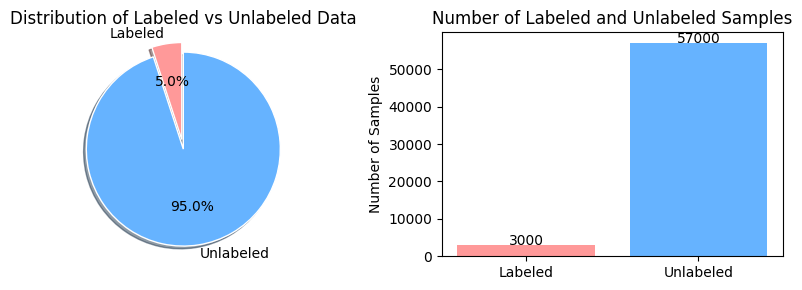

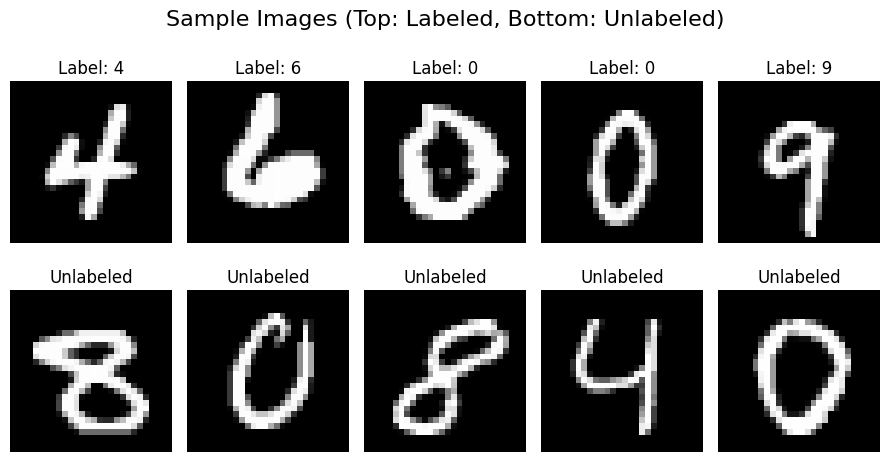

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the sizes
total_size = len(mnist_train)
labeled_size = len(labeled_set)
unlabeled_size = len(unlabeled_set)

# Create a pie chart
sizes = [labeled_size, unlabeled_size]
labels = ['Labeled', 'Unlabeled']
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode the 1st slice (Labeled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Pie chart
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, shadow=True, wedgeprops={'edgecolor': 'white'})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax1.set_title('Distribution of Labeled vs Unlabeled Data')

# Bar chart
ax2.bar(['Labeled', 'Unlabeled'], [labeled_size, unlabeled_size], color=colors)
ax2.set_ylabel('Number of Samples')
ax2.set_title('Number of Labeled and Unlabeled Samples')

# Add value labels on the bars
for i, v in enumerate([labeled_size, unlabeled_size]):
    ax2.text(i, v + 0.5, str(v), ha='center')

plt.tight_layout()
plt.show()

# Display some sample images
fig, axes = plt.subplots(2, 5, figsize=(9, 5))
fig.suptitle("Sample Images (Top: Labeled, Bottom: Unlabeled)", fontsize=16)

for i, ax in enumerate(axes[0]):
    img, label = labeled_set[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

for i, ax in enumerate(axes[1]):
    img, _ = unlabeled_set[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title("Unlabeled")

plt.tight_layout()
plt.show()

In [5]:
import torchvision.transforms.functional as VisF

class WeakAugmentation:
    def __init__(self, rotate_degrees=5, translate_pixels=2, p_rotate=0.5, p_translate=0.5):
        self.rotate_degrees = rotate_degrees
        self.translate_pixels = translate_pixels
        self.p_rotate = p_rotate
        self.p_translate = p_translate

    def __call__(self, img):
        # Rotation
        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rotate_degrees, self.rotate_degrees)
            img = VisF.rotate(img, angle)

        # Translation
        if random.random() < self.p_translate:
            dx = random.randint(-self.translate_pixels, self.translate_pixels)
            dy = random.randint(-self.translate_pixels, self.translate_pixels)
            img = VisF.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0)

        return img

In [6]:
class StrongAugmentation:
    def __init__(self, rotate_degrees=10, translate_pixels=5, shear_degrees=5,
                 p_rotate=0.6, p_translate=0.6, p_shear=0.6):
        self.rotate_degrees = rotate_degrees
        self.translate_pixels = translate_pixels
        self.shear_degrees = shear_degrees
        self.p_rotate = p_rotate
        self.p_translate = p_translate
        self.p_shear = p_shear

    def __call__(self, img):
        # Rotation
        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rotate_degrees, self.rotate_degrees)
            img = VisF.rotate(img, angle)

        # Translation
        if random.random() < self.p_translate:
            dx = random.randint(-self.translate_pixels, self.translate_pixels)
            dy = random.randint(-self.translate_pixels, self.translate_pixels)
            img = VisF.affine(img, angle=0, translate=(dx, dy), scale=1, shear=0)

        # Shear
        if random.random() < self.p_shear:
            shear_angle = random.uniform(-self.shear_degrees, self.shear_degrees)
            img = VisF.affine(img, angle=0, translate=(0, 0), scale=1, shear=shear_angle)

        return img

In [7]:
def get_semi_supervised_dataloader(
        labeled_loader,
        unlabeled_loader,
        weak_aug_transform,
        strong_aug_transform
        ):
    labeled_iter = cycle(labeled_loader)
    unlabeled_iter = cycle(unlabeled_loader)

    while True:
        labeled_data, target = next(labeled_iter)
        unlabeled_data, _ = next(unlabeled_iter)

        # Apply augmentation to unlabeled data
        weak_aug_unlabeled_data = torch.stack([weak_aug_transform(img) for img in unlabeled_data])
        strong_aug_unlabeled_data = torch.stack([strong_aug_transform(img) for img in unlabeled_data])

        yield labeled_data, target, unlabeled_data, weak_aug_unlabeled_data, strong_aug_unlabeled_data

In [8]:
weak_aug_transform = transforms.Compose([
    WeakAugmentation(),
])
strong_aug_transform = transforms.Compose([
    StrongAugmentation(),
])

batch_size = 64
labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

semi_supervised_loader = get_semi_supervised_dataloader(
        labeled_loader,
        unlabeled_loader,
        weak_aug_transform,
        strong_aug_transform
    )

In [9]:
def visualize_semi_supervised_data(
    semi_supervised_loader,
    num_samples=5
):
    # Get a batch of data
    labeled_data, targets, unlabeled_data, weak_aug_unlabeled_data, strong_aug_unlabeled_data = next(semi_supervised_loader)

    # Create a figure with 4 rows and num_samples columns
    fig, axes = plt.subplots(4, num_samples, figsize=(10, 6))
    fig.suptitle("Samples from Semi-Supervised Dataloader", fontsize=16)

    # Function to denormalize the images (assuming normalization was applied)
    denormalize = transforms.Compose([
        transforms.Normalize(mean=[0], std=[1/0.3081]),
        transforms.Normalize(mean=[-0.1307], std=[1]),
    ])

    for i in range(num_samples):
        # Labeled data
        ax = axes[0, i]
        img = denormalize(labeled_data[i]).squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {targets[i].item()}")
        ax.axis('off')

        # Original unlabeled data
        ax = axes[1, i]
        img = denormalize(unlabeled_data[i]).squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title("Original Unlabeled")
        ax.axis('off')

        # Weakly augmented unlabeled data
        ax = axes[2, i]
        img = denormalize(weak_aug_unlabeled_data[i]).squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title("Weak Aug")
        ax.axis('off')

        # Strongly augmented unlabeled data
        ax = axes[3, i]
        img = denormalize(strong_aug_unlabeled_data[i]).squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title("Strong Aug")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

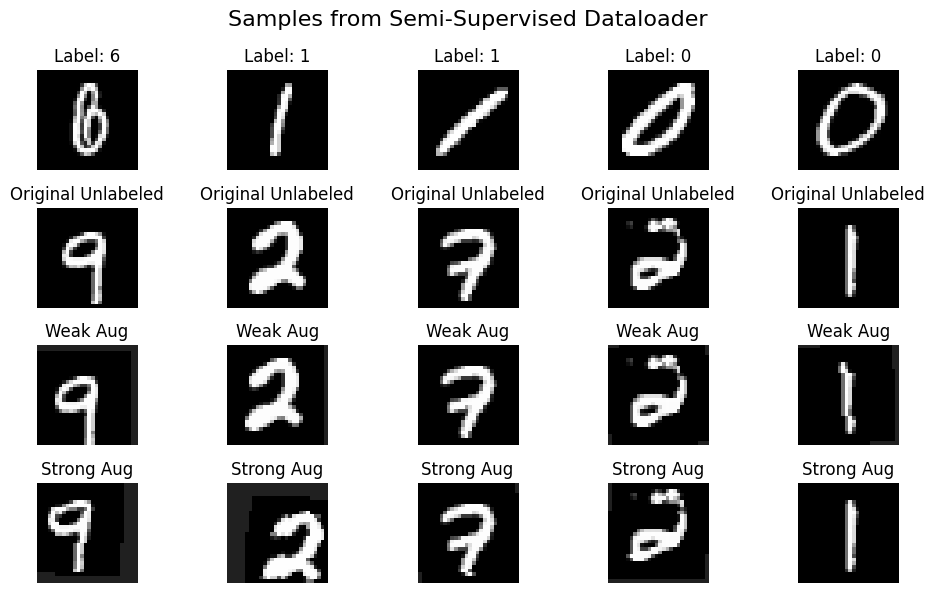

In [10]:
visualize_semi_supervised_data(
    semi_supervised_loader
)

In [11]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [12]:
# EMA update function
def update_ema_variables(model, ema_model, alpha, global_step):
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


def train(student_model, teacher_model, device, semi_supervised_loader, optimizer, scheduler, total_iterations, ema_decay):
    student_model.train()
    teacher_model.train()

    for iteration in range(1, total_iterations + 1):
        labeled_data, targets, unlabeled_data, weak_aug_unlabeled_data, strong_aug_unlabeled_data = next(semi_supervised_loader)
        labeled_data, target = labeled_data.to(device), targets.to(device)
        weak_aug_unlabeled_data, strong_aug_unlabeled_data = weak_aug_unlabeled_data.to(device), strong_aug_unlabeled_data.to(device)

        optimizer.zero_grad()

        # Supervised loss
        output = student_model(labeled_data)
        loss = nn.functional.nll_loss(output, target)

        # Unsupervised loss (consistency regularization)
        with torch.no_grad():
            teacher_output = teacher_model(weak_aug_unlabeled_data)
        student_output = student_model(strong_aug_unlabeled_data)
        consistency_loss = nn.functional.mse_loss(student_output, teacher_output)

        # Combined loss
        combined_loss = loss + consistency_loss
        combined_loss.backward()
        optimizer.step()
        scheduler.step()

        update_ema_variables(student_model, teacher_model, ema_decay, iteration)

        if iteration % 500 == 0:
            # Update teacher model

            with torch.no_grad():
                # Accuracy on labeled data
                labeled_outputs = student_model(labeled_data)
                _, labeled_predicted = torch.max(labeled_outputs.data, 1)
                labeled_correct = (labeled_predicted == target).sum().item()
                labeled_accuracy = labeled_correct / labeled_data.size(0) * 100.0

                # Accuracy on unlabeled data (using teacher's predictions as pseudo-labels)
                unlabeled_outputs = student_model(strong_aug_unlabeled_data)
                _, unlabeled_predicted = torch.max(unlabeled_outputs.data, 1)
                teacher_outputs = teacher_model(weak_aug_unlabeled_data)
                _, teacher_predicted = torch.max(teacher_outputs.data, 1)
                unlabeled_correct = (unlabeled_predicted == teacher_predicted).sum().item()
                unlabeled_accuracy = unlabeled_correct / unlabeled_outputs.size(0) * 100.0

            current_lr = optimizer.param_groups[0]['lr']
            print(f'Iteration: {iteration}/{total_iterations} '
                f'({100. * iteration / total_iterations:.0f}%)\t'
                f'Learning Rate: {current_lr:.6f}\t'
                f'Loss: {loss.item():.4f}\t'
                f'Consistency Loss: {consistency_loss.item():.4f}\t'
                f'Labeled Accuracy: {labeled_accuracy:.2f}%\t'
                f'Unlabeled Accuracy: {unlabeled_accuracy:.2f}%')

        if iteration % 1000 == 0:
            test(student_model, device, DataLoader(mnist_test, batch_size=1000, shuffle=False))



In [13]:
# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.2f}%)\n')

In [14]:
from torch.optim.lr_scheduler import StepLR  # or any other scheduler you prefer

# Set up device, models, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = Net().to(device)
teacher_model = copy.deepcopy(student_model)

# Initial learning rate
initial_lr = 0.001

# Create the optimizer
optimizer = optim.Adam(student_model.parameters(), lr=initial_lr)

# Create a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

# DataLoaders
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

# Training loop
ema_decay = 0.999
total_iterations = 10000
train(student_model, teacher_model, device, semi_supervised_loader, optimizer, scheduler, total_iterations, ema_decay)

# Final evaluation
print("Final evaluation of the student model:")
test(student_model, device, test_loader)
print("Final evaluation of the teacher model:")
test(teacher_model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
<ipython-input-12-210936e3a65e>:5: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


Iteration: 500/10000 (5%)	Learning Rate: 0.001000	Loss: 0.5788	Consistency Loss: 0.6829	Labeled Accuracy: 95.31%	Unlabeled Accuracy: 59.38%
Iteration: 1000/10000 (10%)	Learning Rate: 0.000900	Loss: 0.4731	Consistency Loss: 0.4637	Labeled Accuracy: 98.44%	Unlabeled Accuracy: 73.44%

Test set: Average loss: 0.4983, Accuracy: 9719/10000 (97.19%)

Iteration: 1500/10000 (15%)	Learning Rate: 0.000900	Loss: 0.2579	Consistency Loss: 0.4712	Labeled Accuracy: 100.00%	Unlabeled Accuracy: 85.94%
Iteration: 2000/10000 (20%)	Learning Rate: 0.000810	Loss: 0.1844	Consistency Loss: 0.5765	Labeled Accuracy: 100.00%	Unlabeled Accuracy: 84.38%

Test set: Average loss: 0.3981, Accuracy: 9750/10000 (97.50%)

Iteration: 2500/10000 (25%)	Learning Rate: 0.000810	Loss: 0.1441	Consistency Loss: 1.0272	Labeled Accuracy: 100.00%	Unlabeled Accuracy: 85.94%
Iteration: 3000/10000 (30%)	Learning Rate: 0.000729	Loss: 0.1326	Consistency Loss: 0.8863	Labeled Accuracy: 100.00%	Unlabeled Accuracy: 92.19%

Test set: Average